# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on March 3 at 2pm.**

In [ ]:
print('Aaron Elliot')

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/bahargam/506/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

In [50]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as hr
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from sklearn import mixture

DataList=[]

CategoriesCounter={}
CategoriesTop20=[]

i = 0
with open('yelp_academic_dataset_business.json', encoding = "ISO-8859-1") as Json:
    for Business in Json:
        data = json.loads(Business)
        if data["city"]=="Las Vegas" and data["state"]=="NV" and 'Restaurants' in data["categories"]:
            for typ in data["categories"]:
                if typ in CategoriesCounter:
                    CategoriesCounter[typ]+=1
                elif typ != 'Restaurants':
                    CategoriesCounter[typ]=1
            DataList.append(data)
del Json

for Ct in CategoriesCounter.items(): # This sorts out the top 100 contributors, and puts them in Top100
    if len(CategoriesTop20)<20:
        CategoriesTop20.append(Ct)
    elif Ct[1]>CategoriesTop20[0][1]:
        CategoriesTop20[0] = Ct
    CategoriesTop20 = sorted(CategoriesTop20, key=lambda k: k[1])
for X in range(0,20):
    CategoriesTop20[X] = CategoriesTop20[X][0]
del CategoriesCounter


for X in range(len(DataList)):
    tempDic = {}
    for Cat in CategoriesTop20:
        if Cat in DataList[X]['categories']:
            # Weight chosen here. The value .1 was because
            # it appeared to be a breakpoint of domination
            # of Resturant Type vs Long&Lat in initial K-means
            # trials.
            tempDic[Cat] = .1 #weighted here
        else:
            tempDic[Cat] = 0
    tempDic['...Lat'] = DataList[X]['latitude']
    tempDic['...Long'] = DataList[X]['longitude']
    DataList[X] = tempDic.copy()
    
dfBiz = pd.DataFrame(DataList)
"Finished"

'Finished'

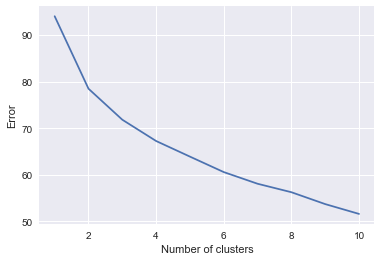

In [36]:
%matplotlib inline
error = np.zeros(11)
for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(dfBiz)
    error[k] = kmeans.inertia_
    
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')

In [39]:

distanceMatrix = pdist(dfBiz,'euclidean')

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=100)
km = kmeans.fit_predict(dfBiz)
print (km[0:40])
# The choice of 3 cluseters was because it was associated with the last
# large change in slope, with the drop at k=4 being almost non-existant.

ck = hr.fcluster(hr.linkage(distanceMatrix, method='complete'), .40,'distance')
print (set(ck))
print (ck[0:40])
# The choice in distance as .4 was because it was associated with 3
# clusters as we already showed in k-means.

gmm = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(dfBiz)
gc = gmm.predict(dfBiz)
print (set(gc))
print (gc[0:40])
# The choice in covariance being full was because it meant the fewest
# assumptions. It was an accum's razor situation.
# Futhermore 3 components was chosen to again be consistant with the
# k-mean's result.
    


[1 2 0 1 0 0 2 0 2 0 2 0 0 0 0 0 0 0 0 0 2 1 2 2 0 0 0 0 2 0 0 1 2 0 2 2 0
 0 0 0]
{1, 2, 3}
[2 1 3 3 3 3 2 2 2 3 2 3 3 2 2 2 2 3 2 2 2 2 2 2 3 3 2 2 3 3 2 3 1 3 3 2 2
 2 3 3]
{0, 1, 2}
[2 1 2 2 0 0 2 2 1 2 2 0 0 2 2 0 2 2 2 2 2 0 1 2 0 1 2 2 1 2 2 2 2 0 2 1 2
 2 2 2]


Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

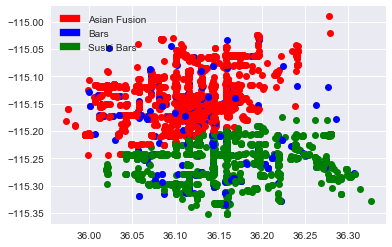

In [88]:
%matplotlib inline
import matplotlib.patches as mpatches

def CategoryClusters(Cl):
    
    Top20A = np.zeros(20)
    Top20B = np.zeros(20)
    Top20C = np.zeros(20)
    avg20 = np.zeros(20)
    for X in range(len(Cl)):
        if Cl[X] == 0:
            for i in range(20):
                Top20A[i] += dfBiz.get_value(X,CategoriesTop20[i])
                avg20[i] += dfBiz.get_value(X,CategoriesTop20[i])/3
        if Cl[X] == 1:
            for i in range(20):
                Top20B[i] += dfBiz.get_value(X,CategoriesTop20[i])
                avg20[i] += dfBiz.get_value(X,CategoriesTop20[i])/3
        if Cl[X] == 2:
            for i in range(20):
                Top20C[i] += dfBiz.get_value(X,CategoriesTop20[i])
                avg20[i] += dfBiz.get_value(X,CategoriesTop20[i])/3
    MaxA=-10000
    Aind=0
    MaxB=-10000
    Bind=0
    MaxC=-10000
    Cind=0
    for i in range(20):
        if Top20A[i]/avg20[i]>MaxA:
            Aind=i
            MaxA=Top20A[i]-avg20[i]
        if Top20B[i]/avg20[i]>MaxB:
            Bind=i
            MaxB=Top20B[i]-avg20[i]
        if Top20C[i]/avg20[i]>MaxC:
            Cind=i
            MaxC=Top20C[i]-avg20[i]
    return(CategoriesTop20[Aind],CategoriesTop20[Bind],CategoriesTop20[Cind])


            
Labels = CategoryClusters(km)
green_patch = mpatches.Patch(color='green', label=Labels[2])
blue_patch = mpatches.Patch(color='blue', label=Labels[1])
red_patch = mpatches.Patch(color='red', label=Labels[0])
plt.legend(handles=[red_patch,blue_patch,green_patch])

def findCentroids ():
    for X in range(len(Clustering)): 
        if Clustering[X] == 0:
            plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'red')
        if Clustering[X] == 1:
            plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'blue')
        if Clustering[X] == 2:
            plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'green')

        

def printClusters (Clustering):
    for X in range(len(Clustering)): 
        if Clustering[X] == 0:
            plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'red')
        if Clustering[X] == 1:
            plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'blue')
        if Clustering[X] == 2:
            plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'green')
printClusters(km)


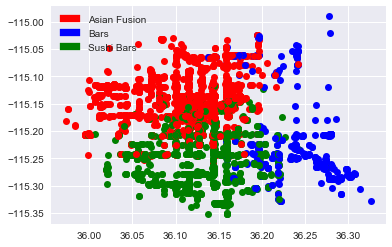

In [90]:
%matplotlib inline

Cl = ck
Top20A = np.zeros(20)
Top20B = np.zeros(20)
Top20C = np.zeros(20)
avg20 = np.zeros(20)
for X in range(len(Cl)):
    if Cl[X] == 3:
        for i in range(20):
            Top20A[i] += dfBiz.get_value(X,CategoriesTop20[i])
            avg20[i] += dfBiz.get_value(X,CategoriesTop20[i])/3
    if Cl[X] == 1:
        for i in range(20):
            Top20B[i] += dfBiz.get_value(X,CategoriesTop20[i])
            avg20[i] += dfBiz.get_value(X,CategoriesTop20[i])/3
    if Cl[X] == 2:
        for i in range(20):
            Top20C[i] += dfBiz.get_value(X,CategoriesTop20[i])
            avg20[i] += dfBiz.get_value(X,CategoriesTop20[i])/3
MaxA=-10000
Aind=0
MaxB=-10000
Bind=0
MaxC=-10000
Cind=0
for i in range(20):
    if Top20A[i]/avg20[i]>MaxA:
        Aind=i
        MaxA=Top20A[i]-avg20[i]
    if Top20B[i]/avg20[i]>MaxB:
        Bind=i
        MaxB=Top20B[i]-avg20[i]
    if Top20C[i]/avg20[i]>MaxC:
        Cind=i
        MaxC=Top20C[i]-avg20[i]

            
Labels = CategoryClusters(km)
green_patch = mpatches.Patch(color='green', label=Labels[2])
blue_patch = mpatches.Patch(color='blue', label=Labels[1])
red_patch = mpatches.Patch(color='red', label=Labels[0])
plt.legend(handles=[red_patch,blue_patch,green_patch])

for X in range(len(ck)): 
    if ck[X] == 3:
        plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'red')
    if ck[X] == 1:
        plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'blue')
    if ck[X] == 2:
        plt.plot(dfBiz[X:X+1]['...Lat'],dfBiz[X:X+1]['...Long'],'o', color = 'green')

        

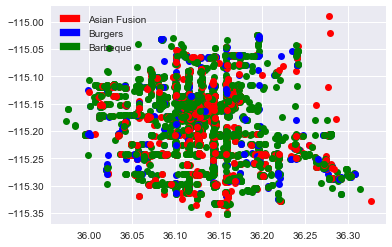

In [91]:
%matplotlib inline


Labels = CategoryClusters(gc)
green_patch = mpatches.Patch(color='green', label=Labels[2])
blue_patch = mpatches.Patch(color='blue', label=Labels[1])
red_patch = mpatches.Patch(color='red', label=Labels[0])
plt.legend(handles=[red_patch,blue_patch,green_patch])


printClusters(gc)
        

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

In [ ]:
# The main results from my analysis were as follows.
# The gaussian mixtures model appeared to
# regard the latitude and longitude as importantly as the type of resturants.
# The GMM has all three clusters scattered together, except the "burger"
# cluster is scattered throughout the map, with the "Asian Fusion" and
# "barbeque" fighting for the center.

# The heirarchical clustering model appeared to regard latitude and longitude
# much more significantly, with the top dominated by the "Asian Fusion" group,
# the bottom dominated by the "Sushi Bars" group, and the right by the "Bars" group.

# The similar to the heirachical clustering model, the k-means model resulted
# in the top being dominated by "Asian Fusion" and the bottom by the "Sushi Bars"
# However, the similarity ends there, with the third group "Bars" being spread
# throughout the map.

# The "best" method is impossible to evaluate objectively at this time. Howerever,
# when I want to find a good place to culinary district, I don't want it to be
# defined by only location or only type of food. I want it to be defined by a mix of
# the two. So in my opinion, the current K-Means results are superior to that of GMM or
# Heirarchical Clustering.

# However, given a different weight for the type of resturants (.1 was used here)
# the results would have been drastically different, as to which feature dominated which
# method's results. Furthermore, the value of .1 was only chosen because it was
# such a breakpoint in initial k-means trials. Thus giving that method an edge in
# this unobjective evaluation.


----------